In [1]:
import numpy as np
import xarray as xr
from glob import glob
import copy

from oceanmixedlayers import oceanmixedlayers
import gsw as gsw

import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean

from Paths import Figure_Save_Path, Argo_Path, SST_Path

%matplotlib inline


def IsVarThere(hndl,VAR):
    CHECK = [A for A in hndl.data_vars  if A==VAR]
    return len(CHECK)>0


plt.rcParams["font.family"] = "Serif"

OK


<ipython-input-2-504a33c9edb8>:257: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  CB=ax.pcolormesh(np.broadcast_to(range(sum(GOOD)),np.shape(ZZ)),


204


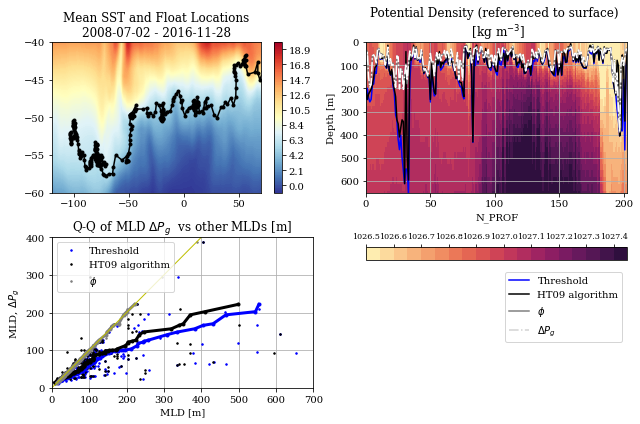

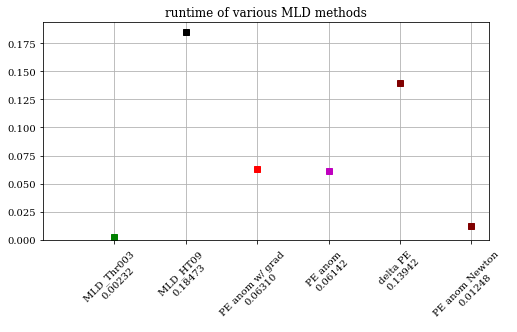

In [2]:
# Load in some Argo data for examples of using the omld package
#PATH = Argo_Path+'/dac/aoml/3900331/'
#PATH = Argo_Path+'/dac/aoml/3900451/'
PATH = Argo_Path+'/dac/aoml/3900660/'
#Holte and Talley sample
#PATH = Argo_Path+'/dac/aoml/3900621/'


PROFFILE = glob(PATH+'/*_prof.nc')

with xr.open_dataset(PROFFILE[0]) as hndl:

    if ( (IsVarThere(hndl,'TEMP'))&(IsVarThere(hndl,'PSAL'))):
        print('OK')
        NP = hndl.N_PROF.size
        NZ = hndl.N_LEVELS.size
        Z_c_2d       = np.zeros([NP,NZ])+np.NaN
        dZ_2d        = np.zeros([NP,NZ])+np.NaN
        P_c_2d       = np.zeros([NP,NZ])+np.NaN
        dP_2d        = np.zeros([NP,NZ])+np.NaN
        CT_c_2d      = np.zeros([NP,NZ])+np.NaN
        PSal_c_2d    = np.zeros([NP,NZ])+np.NaN
        dRho0dz_c_2d = np.zeros([NP,NZ])+np.NaN
        Rho0_c_2d    = np.zeros([NP,NZ])+np.NaN
        GOOD         = np.zeros([NP],dtype=bool)
        for p in range(NP):
            DayQC = float(hndl.JULD_QC[p])
            PosQC = float(hndl.POSITION_QC[p])
            if (np.max(DayQC==np.array([1,2,5,8]))
                and 
                np.max(PosQC==np.array([1,2,5,8]))):
                
                #QC
                SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)
                
                #Computes in-situ density from T&S, T, or S
                LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                      &
                      ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                      &
                      ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                if (np.sum(LI)>20):
                    Pressure = np.array(hndl.PRES[p,:][LI],dtype=float)
                    PSal = np.array(hndl.PSAL[p,:].values[LI],dtype=float)
                    Temp = np.array(hndl.TEMP[p,:].values[LI],dtype=float)
                    GOOD[p]=True
                else:
                    GOOD[p]=False

                if GOOD[p]:
                    Rho = gsw.density.rho_t_exact(PSal,Temp,Pressure)
                    PSal = gsw.SA_from_SP(PSal,Pressure,hndl.LONGITUDE[p].values,hndl.LATITUDE[p].values)
                    CT = gsw.conversions.CT_from_rho(Rho,PSal,Pressure)[0]
                    CT = gsw.conversions.CT_from_t(PSal,Temp,Pressure)
                    Rho0 = gsw.density.rho(PSal,CT,0)
                    
                    #Set a zero surface pressure bin
                    P_i = np.array([0.]+list(Pressure))
                    
                    #First guess at Z_i from pressure
                    Z_i = -1.*P_i
                    dZ = (Z_i[:-1]-Z_i[1:])
                    
                    if (np.min(dZ)<=0 or np.max(dZ)>100):
                        GOOD[p]=False
                    else:

                        CT_i = np.array([CT[0]]+list(CT))
                        PSal_i = np.array([PSal[0]]+list(PSal))
                        Rho0_i = np.array([Rho0[0]]+list(Rho0))

                        P_c       = 0.5*(P_i[1:]+P_i[:-1])
                        dP        = (P_i[:-1]-P_i[1:])
                        CT_c      = 0.5*(CT_i[1:]+CT_i[:-1])
                        PSal_c    = 0.5*(PSal_i[1:]+PSal_i[:-1])
                        Rho0_c    = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                        dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ

                        #Get density for layer from mean CT and Psal and central pressure
                        Rho = gsw.density.rho(PSal_c,CT_c,P_c)
                        #Compute Z_i referenced to a z=0 surface using layer mean density
                        # and assuming hydrostatic pressure
                        for zi in range(len(Rho)):
                            Z_i[zi+1]=Z_i[zi]+1.e4*dP[zi]/(9.81*Rho[zi])
                        Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                        dZ = (Z_i[:-1]-Z_i[1:])
                        
                        LG = len(Z_c)
                        Energy = 25/9.81
                        CT_c_2d[p,:LG] = CT_c
                        PSal_c_2d[p,:LG] = PSal_c
                        P_c_2d[p,:LG] = P_c
                        Z_c_2d[p,:LG] = Z_c
                        dRho0dz_c_2d[p,:LG] = dRho0dz_c
                        Rho0_c_2d[p,:LG] = Rho0_c
                        dZ_2d[p,:LG] = dZ
                        dP_2d[p,:LG] = dP
Timing = True

if Timing:
    import time

# Compute a series of MLDs using the threshold method:
if Timing: time_0=time.time()
MLD_003,MLD_003i = oceanmixedlayers.threshold(-Z_c_2d[GOOD,:].T,
                                              Rho0_c_2d[GOOD,:].T,
                                              delta=0.03,
                                              ref=10
                                             )  

# Compute a series of MLDs using the gradient method:
if Timing: time_1=time.time()
MLD_gradient,MLD_gradienti = oceanmixedlayers.gradient(-Z_c_2d[GOOD,:].T,
                                                       -Rho0_c_2d[GOOD,:].T,
                                                       critical_gradient=0.0005
                                                      )  

# Compute a series of MLDs using the linearfit method
if Timing: time_2=time.time()
MLD_linfit,MLD_linfiti = oceanmixedlayers.linearfit(-Z_c_2d[GOOD,:].T,
                                                    -Rho0_c_2d[GOOD,:].T,
                                                    error_tolerance=1.e-10)  

# Compute a series of MLDs using the Holte and Talley algorithm method
if Timing: time_3=time.time()
OUT = oceanmixedlayers.holtetalley(-Z_c_2d[GOOD,:].T,
                                 PSal_c_2d[GOOD,:].T,
                                 CT_c_2d[GOOD,:].T,
                                 Rho0_c_2d[GOOD,:].T)
MLD_ht=OUT[2]

# Compute a series of MLDs using the PE anomaly with a gradient in Rho0
if Timing: time_4=time.time()
MLD_pelin = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                            dZ_2d[GOOD,:].T,
                                            Rho0_c_2d[GOOD,:].T,
                                            dRho0dz_c_2d[GOOD,:].T,
                                            energy=10.,
                                            gradient=True
                                           )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_5=time.time()
MLD_pe = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=10.,
                                         gradient=False
                                        )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_6=time.time()
MLD_delta = oceanmixedlayers.mld_delta_pe(P_c_2d[GOOD,:].T,
                                          dP_2d[GOOD,:].T,
                                          CT_c_2d[GOOD,:].T,
                                          PSal_c_2d[GOOD,:].T,
                                          energy=10.,
                                         )
if Timing: time_7=time.time()
    

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
MLD_pe_Newton = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=10.,
                                         gradient=False,
                                          iteration='Newton'
                                        )

if Timing: time_8=time.time()

    
# Compute the PE anomaly for the threshold MLD
e_MLD_003 = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                        dZ_2d[GOOD,:].T,
                                        Rho0_c_2d[GOOD,:].T,
                                        dRho0dz_c_2d[GOOD,:].T,
                                        depth=-MLD_003,
                                        gradient=True
                                       )
# Compute the PE anomaly for the gradient MLD
e_MLD_gradient = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                             dZ_2d[GOOD,:].T,
                                             Rho0_c_2d[GOOD,:].T,
                                             dRho0dz_c_2d[GOOD,:].T,
                                             depth=-MLD_gradient,
                                             gradient=True
                                            )
# Compute the PE anomaly for the linearfit MLD
e_MLD_linfit = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                           dZ_2d[GOOD,:].T,
                                           Rho0_c_2d[GOOD,:].T,
                                           dRho0dz_c_2d[GOOD,:].T,
                                           depth=-MLD_linfit,
                                           gradient=True
                                          )
# Compute the PE anomaly for the Holte and Talley MLD
e_MLD_ht = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                       dZ_2d[GOOD,:].T,
                                       Rho0_c_2d[GOOD,:].T,
                                       dRho0dz_c_2d[GOOD,:].T,
                                       depth=-MLD_ht,
                                       gradient=True
                                      )
# Compute the PE anomaly for the PE anomaly MLD (w/ gradient)
e_MLD_pelin = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_pelin,
                                          gradient=True
                                         )
# Compute the PE anomaly for the PE anomaly MLD
e_MLD_pe = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                       dZ_2d[GOOD,:].T,
                                       Rho0_c_2d[GOOD,:].T,
                                       dRho0dz_c_2d[GOOD,:].T,
                                       depth=-MLD_pe,
                                       gradient=True
                                      )
# Compute the PE anomaly for the PE anomaly MLD
e_MLD_delta = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_delta,
                                          gradient=True
                                         )

TI0=str(hndl.JULD[GOOD][0].values)[:10]
TIf=str(hndl.JULD[GOOD][-1].values)[:10]


f_,ax_=plt.subplots(2,2,figsize=(9,6))


hhh = xr.open_dataset('/net2/bgr/Data/Gas_Fluxes/Datasets/SST/sst.mnmean.nc').sel(time=slice(TI0,TIf)).mean(dim='time')
lon = hhh.lon.values
lon[lon>180]-=360
xi = np.argsort(lon)
ax=ax_.ravel()[0]
CB=ax.contourf(lon[xi],hhh.lat,hhh.sst[:,xi],np.arange(-1,20,0.1),cmap='RdYlBu_r')
ax.plot(hndl.LONGITUDE,hndl.LATITUDE,'k.-')
ax.set_xlim(-120,70)
ax.set_ylim(-60,-40)
ax.set_title('Mean SST and Float Locations\n'+TI0+' - '+TIf)
plt.colorbar(CB,ax=ax)

ax=ax_.ravel()[1]
ZZ = np.copy(-Z_c_2d[GOOD,:].T)
ZZ[np.isnan(ZZ)]=2000
cmap = copy.copy(cmocean.cm.matter)
levels=np.arange(1026.5,1027.5,0.05)
CB=ax.pcolormesh(np.broadcast_to(range(sum(GOOD)),np.shape(ZZ)),
                  ZZ,
                  Rho0_c_2d[GOOD,:].T,cmap=cmap,
                 norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                 )
ax.plot(MLD_003,'b-',label='Threshold')
ax.plot(MLD_ht,'k-',label='HT09 algorithm')
ax.plot(MLD_pe,'-',color='gray',label=r'$\phi$')
ax.plot(MLD_delta,'-.',color='w',label=r'$\Delta P_g$')
ax.grid(True)
ax.set_title('MLD [m]')
ax.set_xlabel('N_PROF')

ax.set_xlim(0,)
ax.set_ylim(650,0)

ax.set_title('Potential Density (referenced to surface) \n [kg m$^{-3}$] ')
ax.set_xlabel('N_PROF')
ax.set_ylabel('Depth [m]')

ax=ax_.ravel()[3]
ax.plot(np.NaN,'b-',label='Threshold')
ax.plot(np.NaN,'k-',label='HT09 algorithm')
ax.plot(np.NaN,'-',color='gray',label=r'$\phi$')
ax.plot(np.NaN,'-.',color='lightgray',label=r'$\Delta P_g$')
ax.legend()
ax.axis("off")
cb=plt.colorbar(CB,ax=ax,orientation='horizontal',location='top')
cb.ax.tick_params(labelsize=8)

ax=ax_.ravel()[2]
ax.plot(MLD_003,MLD_delta,'b.',label='Threshold',markersize=3)
ax.plot(MLD_ht,MLD_delta,'k.',label='HT09 algorithm',markersize=3)
ax.plot(MLD_pe,MLD_delta,'.',color='gray',label='$\phi$',markersize=3)
ax.set_xlim(0,700)
ax.set_ylim(0,400)
ax.grid(True)
ax.set_title('MLD $\Delta P_g$  vs other MLDs [m]')
ax.set_ylabel('MLD, $\Delta P_g$')
ax.set_xlabel('MLD [m]')
ax.legend(loc=2)

ax=ax_.ravel()[2]
VDel=[];V003=[];VHT=[];VPhi=[]
for ii in range(100):
    VDel.append(np.nanpercentile(MLD_delta,ii))
    V003.append(np.nanpercentile(MLD_003,ii))
    VHT.append(np.nanpercentile(MLD_ht,ii))
    VPhi.append(np.nanpercentile(MLD_pe,ii))
ax.plot(V003,VDel,'b.-',label='0.03',linewidth=3)
ax.plot(VHT,VDel,'k.-',label='HT',linewidth=3)
ax.plot(VPhi,VDel,'.-',color='gray',label='$\phi$',linewidth=3)
ax.set_xlim(0,700)
ax.set_ylim(0,400)
ax.plot([0,1000],[0,1000],'-',color='y',linewidth=1)
ax.grid(True)
ax.set_title('Q-Q of MLD $\Delta P_g$  vs other MLDs [m]')
ax.set_ylabel('MLD, $\Delta P_g$')
ax.set_xlabel('MLD [m]')

f_.tight_layout()
f_.savefig('Figures/F9_Argo_Comparing_Methods_SO.png')

if Timing: 
    plt.figure(figsize=(8,4))
    plt.plot(1,time_1-time_0,'gs')
    plt.plot(2,time_4-time_3,'ks')
    plt.plot(3,time_5-time_4,'rs')
    plt.plot(4,time_6-time_5,'ms')
    plt.plot(5,time_7-time_6,'s',color='maroon')
    plt.plot(6,time_8-time_7,'s',color='maroon')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.grid(True)
plt.xticks([1,2,3,4,5,6],['MLD_Thr003 \n{:6.5f}'.format(time_1-time_0),
                          'MLD_HT09 \n{:6.5f}'.format(time_4-time_3),
                          'PE anom w/ grad \n{:6.5f}'.format(time_5-time_4),
                          'PE anom \n{:6.5f}'.format(time_6-time_5),
                          'delta PE \n{:6.5f}'.format(time_7-time_6),
                          'PE anom Newton \n{:6.5f}'.format(time_8-time_7),],
           rotation=45)
plt.title('runtime of various MLD methods')

print(np.sum(GOOD))

pass;                                 

OK


<ipython-input-3-f71a413694aa>:252: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  CB=ax.pcolormesh(np.broadcast_to(range(sum(GOOD)),np.shape(ZZ)),


209


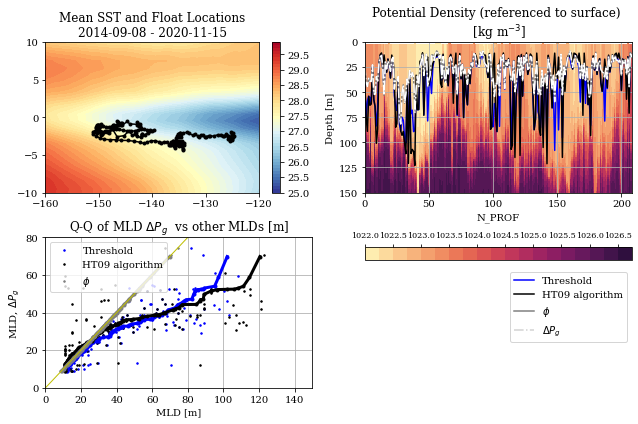

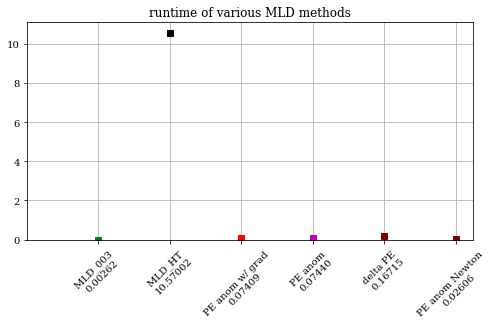

In [3]:
PATH = Argo_Path+'/dac/aoml/5904545/'

PROFFILE = glob(PATH+'/*_prof.nc')

with xr.open_dataset(PROFFILE[0]) as hndl:

    if ( (IsVarThere(hndl,'TEMP'))&(IsVarThere(hndl,'PSAL'))):
        print('OK')
        NP = hndl.N_PROF.size
        NZ = hndl.N_LEVELS.size
        Z_c_2d       = np.zeros([NP,NZ])+np.NaN
        dZ_2d        = np.zeros([NP,NZ])+np.NaN
        P_c_2d       = np.zeros([NP,NZ])+np.NaN
        dP_2d        = np.zeros([NP,NZ])+np.NaN
        CT_c_2d      = np.zeros([NP,NZ])+np.NaN
        PSal_c_2d    = np.zeros([NP,NZ])+np.NaN
        dRho0dz_c_2d = np.zeros([NP,NZ])+np.NaN
        Rho0_c_2d    = np.zeros([NP,NZ])+np.NaN
        GOOD         = np.zeros([NP],dtype=bool)
        for p in range(NP):
            DayQC = float(hndl.JULD_QC[p])
            PosQC = float(hndl.POSITION_QC[p])
            if (np.max(DayQC==np.array([1,2,5,8]))
                and 
                np.max(PosQC==np.array([1,2,5,8]))):
                
                #QC
                SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)
                
                #Computes in-situ density from T&S, T, or S
                LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                      &
                      ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                      &
                      ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                if (np.sum(LI)>20):
                    Pressure = np.array(hndl.PRES[p,:][LI],dtype=float)
                    PSal = np.array(hndl.PSAL[p,:].values[LI],dtype=float)
                    Temp = np.array(hndl.TEMP[p,:].values[LI],dtype=float)
                    GOOD[p]=True
                else:
                    GOOD[p]=False

                if GOOD[p]:
                    Rho = gsw.density.rho_t_exact(PSal,Temp,Pressure)
                    PSal = gsw.SA_from_SP(PSal,Pressure,hndl.LONGITUDE[p].values,hndl.LATITUDE[p].values)
                    CT = gsw.conversions.CT_from_rho(Rho,PSal,Pressure)[0]
                    CT = gsw.conversions.CT_from_t(PSal,Temp,Pressure)
                    Rho0 = gsw.density.rho(PSal,CT,0)
                    
                    #Set a zero surface pressure bin
                    P_i = np.array([0.]+list(Pressure))
                    
                    #First guess at Z_i from pressure
                    Z_i = -1.*P_i
                    dZ = (Z_i[:-1]-Z_i[1:])
                    
                    if (np.min(dZ)<=0 or np.max(dZ)>100):
                        GOOD[p]=False
                    else:

                        CT_i = np.array([CT[0]]+list(CT))
                        PSal_i = np.array([PSal[0]]+list(PSal))
                        Rho0_i = np.array([Rho0[0]]+list(Rho0))

                        P_c       = 0.5*(P_i[1:]+P_i[:-1])
                        dP        = (P_i[:-1]-P_i[1:])
                        CT_c      = 0.5*(CT_i[1:]+CT_i[:-1])
                        PSal_c    = 0.5*(PSal_i[1:]+PSal_i[:-1])
                        Rho0_c    = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                        dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ

                        #Get density for layer from mean CT and Psal and central pressure
                        Rho = gsw.density.rho(PSal,CT_c,P_c)
                        Rho = gsw.density.rho(PSal_c,CT_c,P_c)
                        #Compute Z_i referenced to a z=0 surface using layer mean density
                        # and assuming hydrostatic pressure
                        for zi in range(len(Rho)):
                            Z_i[zi+1]=Z_i[zi]+1.e4*dP[zi]/(9.81*Rho[zi])
                        Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                        dZ = (Z_i[:-1]-Z_i[1:])
                        
                        LG = len(Z_c)
                        Energy = 25/9.81
                        CT_c_2d[p,:LG] = CT_c
                        PSal_c_2d[p,:LG] = PSal_c
                        P_c_2d[p,:LG] = P_c
                        Z_c_2d[p,:LG] = Z_c
                        dRho0dz_c_2d[p,:LG] = dRho0dz_c
                        Rho0_c_2d[p,:LG] = Rho0_c
                        dZ_2d[p,:LG] = dZ
                        dP_2d[p,:LG] = dP
Timing = True

if Timing:
    import time

# Compute a series of MLDs using the threshold method:
if Timing: time_0=time.time()
MLD_003,MLD_003i = oceanmixedlayers.threshold(P_c_2d[GOOD,:].T,
                                              Rho0_c_2d[GOOD,:].T,
                                              delta=0.03,
                                              ref=10
                                             )  

# Compute a series of MLDs using the gradient method:
if Timing: time_1=time.time()
MLD_gradient,MLD_gradienti = oceanmixedlayers.gradient(P_c_2d[GOOD,:].T,
                                                       -Rho0_c_2d[GOOD,:].T,
                                                       critical_gradient=0.0005
                                                      )  

# Compute a series of MLDs using the linearfit method
if Timing: time_2=time.time()
MLD_linfit,MLD_linfiti = oceanmixedlayers.linearfit(P_c_2d[GOOD,:].T,
                                                    -Rho0_c_2d[GOOD,:].T,
                                                    error_tolerance=1.e-10)  

# Compute a series of MLDs using the Holte and Talley algorithm method
if Timing: time_3=time.time()
OUT = oceanmixedlayers.holtetalley(P_c_2d[GOOD,:].T,
                                 PSal_c_2d[GOOD,:].T,
                                 CT_c_2d[GOOD,:].T,
                                 Rho0_c_2d[GOOD,:].T)
MLD_ht=OUT[2]

# Compute a series of MLDs using the PE anomaly with a gradient in Rho0
if Timing: time_4=time.time()
MLD_pelin = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                            dZ_2d[GOOD,:].T,
                                            Rho0_c_2d[GOOD,:].T,
                                            dRho0dz_c_2d[GOOD,:].T,
                                            energy=10.,
                                            gradient=True
                                           )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_5=time.time()
MLD_pe = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=10.,
                                         gradient=False
                                        )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_6=time.time()
MLD_delta = oceanmixedlayers.mld_delta_pe(P_c_2d[GOOD,:].T,
                                          dP_2d[GOOD,:].T,
                                          CT_c_2d[GOOD,:].T,
                                          PSal_c_2d[GOOD,:].T,
                                          energy=10.,
                                         )
if Timing: time_7=time.time()
    

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
MLD_pe_Newton = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=10.,
                                         gradient=False,
                                          iteration='Newton'
                                        )

if Timing: time_8=time.time()

    
# Compute the PE anomaly for the threshold MLD
e_MLD_003 = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                        dZ_2d[GOOD,:].T,
                                        Rho0_c_2d[GOOD,:].T,
                                        dRho0dz_c_2d[GOOD,:].T,
                                        depth=-MLD_003,
                                        gradient=True
                                       )
# Compute the PE anomaly for the gradient MLD
e_MLD_gradient = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                             dZ_2d[GOOD,:].T,
                                             Rho0_c_2d[GOOD,:].T,
                                             dRho0dz_c_2d[GOOD,:].T,
                                             depth=-MLD_gradient,
                                             gradient=True
                                            )
# Compute the PE anomaly for the linearfit MLD
e_MLD_linfit = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                           dZ_2d[GOOD,:].T,
                                           Rho0_c_2d[GOOD,:].T,
                                           dRho0dz_c_2d[GOOD,:].T,
                                           depth=-MLD_linfit,
                                           gradient=True
                                          )
# Compute the PE anomaly for the Holte and Talley MLD
e_MLD_ht = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                       dZ_2d[GOOD,:].T,
                                       Rho0_c_2d[GOOD,:].T,
                                       dRho0dz_c_2d[GOOD,:].T,
                                       depth=-MLD_ht,
                                       gradient=True
                                      )
# Compute the PE anomaly for the PE anomaly MLD (w/ gradient)
e_MLD_pelin = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_pelin,
                                          gradient=True
                                         )
# Compute the PE anomaly for the PE anomaly MLD
e_MLD_pe = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                       dZ_2d[GOOD,:].T,
                                       Rho0_c_2d[GOOD,:].T,
                                       dRho0dz_c_2d[GOOD,:].T,
                                       depth=-MLD_pe,
                                       gradient=True
                                      )
# Compute the PE anomaly for the PE anomaly MLD
e_MLD_delta = oceanmixedlayers.pe_anomaly(Z_c_2d[GOOD,:].T,
                                          dZ_2d[GOOD,:].T,
                                          Rho0_c_2d[GOOD,:].T,
                                          dRho0dz_c_2d[GOOD,:].T,
                                          depth=-MLD_delta,
                                          gradient=True
                                         )

TI0=str(hndl.JULD[GOOD][0].values)[:10]
TIf=str(hndl.JULD[GOOD][-1].values)[:10]


f_,ax_=plt.subplots(2,2,figsize=(9,6))


hhh = xr.open_dataset('/net2/bgr/Data/Gas_Fluxes/Datasets/SST/sst.mnmean.nc').sel(time=slice(TI0,TIf)).mean(dim='time')
lon = hhh.lon.values
lon[lon>180]-=360
xi = np.argsort(lon)
ax=ax_.ravel()[0]
CB=ax.contourf(lon[xi],hhh.lat,hhh.sst[:,xi],np.arange(25,30,0.1),cmap='RdYlBu_r')
ax.plot(hndl.LONGITUDE,hndl.LATITUDE,'k.-')
ax.set_xlim(-160,-120)
ax.set_ylim(-10,10)
ax.set_title('Mean SST and Float Locations\n'+TI0+' - '+TIf)
plt.colorbar(CB,ax=ax)

ax=ax_.ravel()[1]
ZZ = np.copy(-Z_c_2d[GOOD,:].T)
ZZ[np.isnan(ZZ)]=2000
cmap = copy.copy(cmocean.cm.matter)
levels=np.arange(1022,1027,0.25)
CB=ax.pcolormesh(np.broadcast_to(range(sum(GOOD)),np.shape(ZZ)),
                  ZZ,
                  Rho0_c_2d[GOOD,:].T,cmap=cmap,
                 norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                 )
ax.plot(MLD_003,'b-',label='Threshold')
ax.plot(MLD_ht,'k-',label='HT09 algorithm')
ax.plot(MLD_pe,'-',color='gray',label=r'$\phi$')
ax.plot(MLD_delta,'-.',color='w',label=r'$\Delta P_g$')
ax.grid(True)
ax.set_title('MLD [m]')
ax.set_xlabel('N_PROF')

ax.set_xlim(0,)
ax.set_ylim(150,0)

ax.set_title('Potential Density (referenced to surface) \n [kg m$^{-3}$] ')
ax.set_xlabel('N_PROF')
ax.set_ylabel('Depth [m]')

ax=ax_.ravel()[3]
ax.plot(np.NaN,'b-',label='Threshold')
ax.plot(np.NaN,'k-',label='HT09 algorithm')
ax.plot(np.NaN,'-',color='gray',label=r'$\phi$')
ax.plot(np.NaN,'-.',color='lightgray',label=r'$\Delta P_g$')
ax.legend()
ax.axis("off")
cb=plt.colorbar(CB,ax=ax,orientation='horizontal',location='top')
cb.ax.tick_params(labelsize=8)

ax=ax_.ravel()[2]
ax.plot(MLD_003,MLD_delta,'b.',label='Threshold',markersize=3)
ax.plot(MLD_ht,MLD_delta,'k.',label='HT09 algorithm',markersize=3)
ax.plot(MLD_pe,MLD_delta,'.',color='gray',label='$\phi$',markersize=3)
ax.set_xlim(0,150)
ax.set_ylim(0,80)
ax.grid(True)
ax.set_title('MLD $\Delta P_g$  vs other MLDs [m]')
ax.set_ylabel('MLD, $\Delta P_g$')
ax.set_xlabel('MLD [m]')
ax.legend(loc=2)

ax=ax_.ravel()[2]
VDel=[];V003=[];VHT=[];VPhi=[]
for ii in range(100):
    VDel.append(np.nanpercentile(MLD_delta,ii))
    V003.append(np.nanpercentile(MLD_003,ii))
    VHT.append(np.nanpercentile(MLD_ht,ii))
    VPhi.append(np.nanpercentile(MLD_pe,ii))
ax.plot(V003,VDel,'b.-',label='0.03',linewidth=3)
ax.plot(VHT,VDel,'k.-',label='HT',linewidth=3)
ax.plot(VPhi,VDel,'.-',color='gray',label='$\phi$',linewidth=3)
ax.set_xlim(0,150)
ax.set_ylim(0,80)
ax.plot([0,1000],[0,1000],'-',color='y',linewidth=1)
ax.grid(True)
ax.set_title('Q-Q of MLD $\Delta P_g$  vs other MLDs [m]')
ax.set_ylabel('MLD, $\Delta P_g$')
ax.set_xlabel('MLD [m]')

f_.tight_layout()
f_.savefig('Figures/Figure8_Argo_Comparing_Methods_LowLat.png')

if Timing: 
    plt.figure(figsize=(8,4))
    plt.plot(1,time_1-time_0,'gs')
    plt.plot(2,time_4-time_3,'ks')
    plt.plot(3,time_5-time_4,'rs')
    plt.plot(4,time_6-time_5,'ms')
    plt.plot(5,time_7-time_6,'s',color='maroon')
    plt.plot(6,time_8-time_7,'s',color='maroon')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.grid(True)
plt.xticks([1,2,3,4,5,6],['MLD_003 \n{:6.5f}'.format(time_1-time_0),
                          'MLD_HT \n{:6.5f}'.format(time_4-time_3),
                          'PE anom w/ grad \n{:6.5f}'.format(time_5-time_4),
                          'PE anom \n{:6.5f}'.format(time_6-time_5),
                          'delta PE \n{:6.5f}'.format(time_7-time_6),
                          'PE anom Newton \n{:6.5f}'.format(time_8-time_7),],
           rotation=45)
plt.title('runtime of various MLD methods')

print(np.sum(GOOD))


pass;                                                                